In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
 train = pd.read_csv("/content/fake-news_preprocessed-corrected_train.csv")

In [4]:
test = pd.read_csv("/content/fake-news_preprocessed-corrected_test.csv")

In [5]:
train.head()

,Article_ID,Title,Link,Content,Date_posted,Source,Type,Author,Preprocessed_text,Prediction,Prediction_prob,Rescaled_prediction_prob,Annotation_action,Text,Corrected_label
0,2765,NaN,NaN,“Este es un momento para decisiones inteligent...,2021-04-24,elheraldoco,Tweet,NaN,decisión inteligente audaz comprometida derech...,Fake,0.609423,0.109423,Don't Annotate,Source:elheraldoco\n\n Prediction:Fake\n\n Con...,True
1,1137,Gobierno ve motivo electoral en homicidios,https://diario.elmundo.sv/Política/gobierno-ve...,\nLandaverde reportó la captura de 135 persona...,2017-08-16,El Mundo,Web Article,NaN,Landaverde reportar captura 135 persona crimen...,True,0.334340,0.165660,Don't Annotate,Source:El Mundo\n\n Prediction:True\n\n Conten...,True
2,333,"Calleja: ""Los salvadoreños debemos honrar su l...",https://diario.elmundo.sv/Política/calleja-los...,\n El candidato a la presidencia por el...,2017-10-14,El Mundo,Web Article,NaN,candidato presidencia partido ARENA Carlos Cal...,True,0.451580,0.048420,Annotate,Source:El Mundo\n\n Prediction:True\n\n Conten...,True
3,1103,¿Reformarán los diputados el decreto 661 para ...,https://diario.elmundo.sv/Política/reformaran-...,\n\n\r\nLuego de que el presidente de la Repúb...,2020-09-25,El Mundo,Web Article,NaN,presidente República Nayib Bukele publicar dec...,True,0.341478,0.158522,Don't Annotate,Source:El Mundo\n\n Prediction:True\n\n Conten...,True
4,2800,NaN,NaN,#PuntosyComas ADELANTO | Cómo Raniere y NXIVM ...,2020-04-15,SinEmbargoMX,Tweet,NaN,PuntosyComas ADELANTO Raniere NXIVM seducir po...,Fake,0.609423,0.109423,Don't Annotate,Source:SinEmbargoMX\n\n Prediction:Fake\n\n Co...,True


In [6]:
test.head()

,Article_ID,Title,Link,Content,Date_posted,Source,Type,Author,Preprocessed_text,Prediction,Prediction_prob,Rescaled_prediction_prob,Annotation_action,Text,Corrected_label
0,1646,NaN,NaN,@DanyBarraganG @RomiinaGandara 🔴 #EnVivo | #Ca...,2021-08-27,SinEmbargoMX,Tweet,NaN,@DanyBarraganG @RomiinaGandara EnVivo CaféyNot...,True,0.498762,0.001238,Don't Annotate,Source:SinEmbargoMX\n\n Prediction:True\n\n Co...,True
1,1743,NaN,NaN,"Familia de regidora del PRD, favorecida con em...",2018-10-04,proceso,Tweet,NaN,Familia regidora PRD favorecido empleo contrat...,Fake,0.504291,0.004291,Don't Annotate,Source:proceso\n\n Prediction:Fake\n\n Content...,True
2,2212,NaN,NaN,#Economía | @IvanDuque:“De nada sirve recupera...,2021-03-25,ElNuevoSiglo,Tweet,NaN,Economía @ivanduque:“dar servir recuperar crec...,Fake,0.564037,0.064037,Don't Annotate,Source:ElNuevoSiglo\n\n Prediction:Fake\n\n Co...,Fake
3,2793,NaN,NaN,@DanyBarraganG @RomiinaGandara 🔴 #EnVivo | #C...,2021-04-08,SinEmbargoMX,Tweet,NaN,@DanyBarraganG @RomiinaGandara EnVivo CaféyNot...,Fake,0.609423,0.109423,Don't Annotate,Source:SinEmbargoMX\n\n Prediction:Fake\n\n Co...,Fake
4,547,Reserva de plan de vacunación viola resolución...,https://diario.elmundo.sv/Política/reserva-de-...,\nLa reserva de datos se conoció este miércole...,NaN,El Mundo,Web Article,NaN,reserva dato conocer miércoles 24 marzo reserv...,True,0.422629,0.077371,Don't Annotate,Source:El Mundo\n\n Prediction:True\n\n Conten...,Fake


In [7]:
test.shape

(930, 15)

In [8]:
train.shape

(2170, 15)

In [9]:
train["Content"].tolist()

['“Este es un momento para decisiones inteligentes, audaces y comprometidas con los derechos de todas y todos los ciudadanos”, expresó el colectivo político.\r\nhttps://t.co/8OjBYYwjU5',
 '\nLandaverde reportó la captura de 135 personas por los crímenes cometidos entre el viernes y el domingo. / DEM\n\r\nEl ministro de Justicia y Segturidad Pública, Mauricio Ramírez Landaverde, dijo ayer que el incremento de homicidios que hubo entre el viernes y el domingo de la semana pasada contra la población en general,\xa0 los agentes policiales y militares fue un\xa0 “un acto deliberado” de estructuras delincuenciales para incidir en la “opinión pública”, de cara a las elecciones del 4 de marzo del próximo año.\n\r\n“(Estos) grupos no buscan pacificación ni entendimiento. Son organizaciones criminales, su objetivo fundamental es lucrarse, obtener beneficios económicos del cometimiento de actividades ilícitas. No estemos pensando que hay detrás una buena intención de reducir la violencia. Detrás 

In [10]:
 text = ' '.join(str(train["Content"].tolist()))

In [11]:
counts = train["Content"].sample(frac=.07).value_counts()

In [12]:
counts

Es “motivo de orgullo, una dicha enorme” que se unan PAN, PRI y PRD para enfrentarnos, dice AMLO https://t.co/CzuXfEvj2O https://t.co/H92ooYCdB7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [13]:
counts.index = counts.index.map(str)


In [ ]:
#wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(counts)
#plt.figure(figsize=(100, 100))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.show(wordcloud)
 

In [14]:
test["Content"].tolist()

['@DanyBarraganG @RomiinaGandara 🔴 #EnVivo | #CaféyNoticias  \r\n\r\nMaestros de la Sección 7 de la CNTE bloquearon el paso de la camioneta del Presidente  López Obrador, con la finalidad de impedir que encabezara la conferencia de prensa matutina  https://t.co/GoKjL3PDSN\r\n\r\n• Nota completa: \r\nhttps://t.co/C96VS7IaLG https://t.co/NVAeL4klAg',
 'Familia de regidora del PRD, favorecida con empleos y contratos de gobierno municipal de Guanajuato https://t.co/m1FVeWZzM7',
 '#Economía | @IvanDuque:“De nada sirve recuperar crecimiento si hay desigualdad”.\r\nDurante la Asamblea General de Afiliados del Consejo de Empresas Americanas (CEA).\r\n👉https://t.co/ntphhPSktd https://t.co/jmC4D6spuB',
 '@DanyBarraganG @RomiinaGandara 🔴  #EnVivo | #CaféyNoticias \r\n\r\nNo se necesita una Consulta Popular para llevar justicia a las víctimas, sino la voluntad política para crear comisiones de la verdad, consideran víctimas y especialistas \r\nhttps://t.co/ohqoIaxJiF\r\n\r\n • Nota completa:\r\nht

In [15]:
 text = ' '.join(str(test["Content"].tolist()))

In [16]:
counts = test["Content"].sample(frac=.07).value_counts()

In [17]:
counts

La llegada de Emilio Lozoya a México provocará un “temblor político”, prevé Ricardo Monreal\r\nhttps://t.co/eU5SdtluLr https://t.co/7aix98hl0Z                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
#wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(counts)
#plt.figure(figsize=(100, 100))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.show()

In [18]:
test["Content"] = test["Title"] + ' ' + test['Content']
train["Content"] = train["Title"] + ' ' + train['Content']

In [19]:
test["Content"] = test["Content"].apply(lambda x: str(x).lower())
train["Content"] = train["Content"].apply(lambda x: str(x).lower())

In [20]:
test['class'] = 0
train['class'] = 1

In [21]:
test.columns

Index(['Article_ID', 'Title', 'Link', 'Content', 'Date_posted', 'Source',
       'Type', 'Author', 'Preprocessed_text', 'Prediction', 'Prediction_prob',
       'Rescaled_prediction_prob', 'Annotation_action', 'Text',
       'Corrected_label', 'class'],
      dtype='object')

In [22]:
train.columns

Index(['Article_ID', 'Title', 'Link', 'Content', 'Date_posted', 'Source',
       'Type', 'Author', 'Preprocessed_text', 'Prediction', 'Prediction_prob',
       'Rescaled_prediction_prob', 'Annotation_action', 'Text',
       'Corrected_label', 'class'],
      dtype='object')

In [23]:
test = test[["Content", "class"]]
train = train[["Content", "class"]]

In [24]:
test.head(10)

,Content,class
0,nan,0
1,nan,0
2,nan,0
3,nan,0
4,reserva de plan de vacunación viola resolución...,0
5,nan,0
6,estas son las tendencias que se imponen en mod...,0
7,aprueban sanciones contra quienes no usen cubr...,0
8,nan,0
9,nan,0


In [25]:
train.head(10)

,Content,class
0,nan,1
1,gobierno ve motivo electoral en homicidios \nl...,1
2,"calleja: ""los salvadoreños debemos honrar su l...",1
3,¿reformarán los diputados el decreto 661 para ...,1
4,nan,1
5,fmln podrá cambiar a los candidatos electos \n...,1
6,movimiento pide a diputados ceder dinero de vi...,1
7,nan,1
8,nan,1
9,nan,1


In [26]:
data = test.append(train, ignore_index=True)

In [27]:
data.sample(10)

,Content,class
1728,nan,1
1143,nan,1
1840,nan,1
1885,el salvador se suma a condena contra régimen d...,1
3071,nan,1
1604,nan,1
1485,congresista adam kinzinger pide a biden enviar...,1
788,walter durán sería el primer embajador salvado...,0
241,nan,0
1628,álvaro torres reacciona a críticas de funes y ...,1


In [28]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3

     |████████████████████████████████| 10.4 MB 4.9 MB/s 
     |████████████████████████████████| 2.2 MB 54.5 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 12.0 MB 5.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 115 kB 5.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [32]:
pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-ik158bsh
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-ik158bsh
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11756 sha256=7730be7783e275415ce0a8ecfb44d8424778d807cbc02d3725b6a370dc77b2fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-ig0qqhxf/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie


In [33]:
import preprocess_kgptalkie as ps


In [34]:
data["Content"].apply(lambda x: ps.remove_special_chars(x))

0                                                     nan
1                                                     nan
2                                                     nan
3                                                     nan
4       reserva de plan de vacunación viola resolución...
                              ...                        
3095                                                  nan
3096    abaratan regularización de autos chocolate en ...
3097    ambientalistas le hacen este llamado al presid...
3098    al gabacho le faltan abogados a ningún mexican...
3099                                                  nan
Name: Content, Length: 3100, dtype: object

In [35]:
data.head()

,Content,class
0,nan,0
1,nan,0
2,nan,0
3,nan,0
4,reserva de plan de vacunación viola resolución...,0


In [36]:
!pip install gensim==3.8.3

     |████████████████████████████████| 24.2 MB 7.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [37]:
import gensim

In [38]:
y = data['class'].values

In [39]:
data['Content'].tolist()

['nan',
 'nan',
 'nan',
 'nan',
 'reserva de plan de vacunación viola resolución cidh dice dtj \nla reserva de datos se conoció este miércoles 24 de marzo.\n\r\nla reserva total de información que impuso el ministerio de salud al plan nacional de despliegue de vacunación contra el covid-19, al registro de cabinas destinadas a la vacunación y al proceso de adquisición y compra de las vacunas contra el virus, viola la resolución 01/2020 emitida por la comisión interamericana de derechos humanos (cidh), asegura xenia hernández castro, directora ejecutiva de la fundación democracia, transparencia, justicia (dtj).\n\r\nsalud declaró reserva total para dicha información, amparándose en el literal “d” del artículo 19 de la ley de acceso a la información pública (laip), que clasifica de reservada información “que ponga en peligro evidente la vida, la seguridad o la salud de cualquier persona”.\n\r\n\xa0\nabuso de reservas.\r\ncastro explicó que el argumento de la laip utilizado por la cartera 

In [40]:
x = [i.split() for i in data["Content"].tolist()]

In [41]:
print(x)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [42]:
type(x)

list

In [43]:
print(x[0])

['nan']


In [44]:
Dimension = 100
word_2_vec = gensim.models.Word2Vec(sentences=x, size=Dimension, window=10, min_count=1)


In [45]:
len(word_2_vec.wv.vocab)

45150

In [46]:
word_2_vec.wv.vocab

{'nan': <gensim.models.keyedvectors.Vocab at 0x7fdada502350>,
 'reserva': <gensim.models.keyedvectors.Vocab at 0x7fdada502190>,
 'de': <gensim.models.keyedvectors.Vocab at 0x7fdad8410950>,
 'plan': <gensim.models.keyedvectors.Vocab at 0x7fdad84108d0>,
 'vacunación': <gensim.models.keyedvectors.Vocab at 0x7fdad8410d90>,
 'viola': <gensim.models.keyedvectors.Vocab at 0x7fdad8410e10>,
 'resolución': <gensim.models.keyedvectors.Vocab at 0x7fdadc4b1350>,
 'cidh': <gensim.models.keyedvectors.Vocab at 0x7fdad8406b50>,
 'dice': <gensim.models.keyedvectors.Vocab at 0x7fdad8410e50>,
 'dtj': <gensim.models.keyedvectors.Vocab at 0x7fdad8410590>,
 'la': <gensim.models.keyedvectors.Vocab at 0x7fdad8406dd0>,
 'datos': <gensim.models.keyedvectors.Vocab at 0x7fdad8406fd0>,
 'se': <gensim.models.keyedvectors.Vocab at 0x7fdad8406990>,
 'conoció': <gensim.models.keyedvectors.Vocab at 0x7fdad8406e90>,
 'este': <gensim.models.keyedvectors.Vocab at 0x7fdad8406ed0>,
 'miércoles': <gensim.models.keyedvectors.V

In [47]:
word_2_vec['gobiernos']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.21408108, -0.04555292, -0.4699851 ,  0.48855498,  0.15436493,
        0.24301066,  0.61328   ,  0.25969002, -0.21586913, -0.35123897,
       -0.3999536 ,  0.24326406,  0.39586446, -0.18359078, -0.24714607,
       -0.51109445,  0.6111897 ,  0.09303822, -0.47948766, -0.0848197 ,
        0.04874227, -0.15545498,  0.46199277, -0.19378364, -0.28270587,
       -0.13983981, -0.41615483, -0.11885169, -0.55453515, -0.03412526,
        0.40277946, -0.33507013,  0.14602089,  0.23191525,  0.82624984,
        0.34492964, -0.01740452,  0.11524155,  0.22245352,  0.287121  ,
        0.40337443, -0.15539151, -0.06062857, -0.44003993,  0.11041387,
        0.02582708,  0.34811297,  0.09312305,  0.4874081 ,  0.12424817,
       -0.8222578 ,  0.02230683, -0.10426676,  0.42791617, -0.00721529,
        0.27039847, -0.17472237,  0.3976358 , -0.31210867, -0.07646165,
       -0.24272658, -0.7894898 ,  0.42146403,  0.09290342, -0.4515544 ,
        0.07314929,  0.51433945, -0.02077989,  0.22617318, -0.55

In [48]:
word_2_vec.wv.most_similar('gobiernos')

[('valores', 0.9980841875076294),
 ('sectores', 0.997885525226593),
 ('diferentes', 0.9978085160255432),
 ('civiles', 0.9977306127548218),
 ('frontera', 0.9976246953010559),
 ('residentes', 0.9975584149360657),
 ('sociales,', 0.997492253780365),
 ('abusos', 0.9973255395889282),
 ('hallazgos', 0.9973229765892029),
 ('dentro', 0.9972077012062073)]

In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [50]:
X = tokenizer.texts_to_sequences(x)

In [51]:
tokenizer.word_index

{'de': 1,
 'la': 2,
 'el': 3,
 'que': 4,
 'en': 5,
 'a': 6,
 'y': 7,
 'los': 8,
 'del': 9,
 'para': 10,
 'se': 11,
 'las': 12,
 'por': 13,
 'no': 14,
 'con': 15,
 'un': 16,
 'una': 17,
 'es': 18,
 'al': 19,
 'su': 20,
 'lo': 21,
 'nan': 22,
 'como': 23,
 'ha': 24,
 'presidente': 25,
 'más': 26,
 'este': 27,
 'o': 28,
 'asamblea': 29,
 'sus': 30,
 'gobierno': 31,
 'fue': 32,
 'ley': 33,
 'pero': 34,
 'partido': 35,
 'sobre': 36,
 'le': 37,
 'dijo': 38,
 'si': 39,
 'está': 40,
 'también': 41,
 'hay': 42,
 'esta': 43,
 'salvador': 44,
 'ya': 45,
 'han': 46,
 'nacional': 47,
 'sin': 48,
 'contra': 49,
 'son': 50,
 'comisión': 51,
 'diputados': 52,
 'tiene': 53,
 'porque': 54,
 'ser': 55,
 'diputado': 56,
 'entre': 57,
 'estados': 58,
 'millones': 59,
 'legislativa': 60,
 'sala': 61,
 'están': 62,
 'personas': 63,
 'general': 64,
 'acuerdo': 65,
 'fmln': 66,
 'estado': 67,
 'puede': 68,
 'desde': 69,
 'partidos': 70,
 'aseguró': 71,
 'ese': 72,
 'dos': 73,
 'bukele': 74,
 'según': 75,
 'has

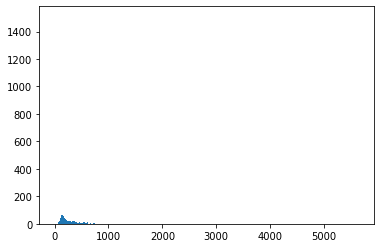

In [52]:
plt.hist([len(x) for x in X], bins=700)
plt.show()

In [53]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])


18

In [54]:
maxlen = 500
x = pad_sequences(X, maxlen=maxlen)

In [55]:
len(x[0])

500

In [56]:
len(x[3])

500

In [57]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [58]:
def get_weight_metrics(model):
  weight_matrix = np.zeros((vocab_size, Dimension))

  for word, i in vocab.items():
    weight_matrix[i] = word_2_vec.wv[word]

  return weight_matrix
   

In [59]:
embedding_vectors = get_weight_metrics(word_2_vec.wv)

In [60]:
embedding_vectors.shape

(45151, 100)

In [61]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [62]:
from tensorflow.keras.callbacks import TensorBoard
import time

In [63]:

Name = 'Fake News Detector-{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(Name))

In [64]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = Dimension, weights = [embedding_vectors], input_length = maxlen, trainable = False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          4515100   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 4,632,477
Trainable params: 117,377
Non-trainable params: 4,515,100
_________________________________________________________________


In [66]:
x.shape

(3100, 500)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(x, y)

In [68]:
type(X_train),type(y_train),X_train.shape

(numpy.ndarray, numpy.ndarray, (2325, 500))

In [69]:
model.fit(X_train, y_train, validation_split=0.3, epochs=100, callbacks=[tensorboard])

Epoch 1/100
51/51 [==============================] - 12s 119ms/step - loss: 0.6387 - acc: 0.6872 - val_loss: 0.6009 - val_acc: 0.7206
Epoch 2/100
51/51 [==============================] - 5s 97ms/step - loss: 0.6256 - acc: 0.6915 - val_loss: 0.5933 - val_acc: 0.7206
Epoch 3/100
51/51 [==============================] - 5s 100ms/step - loss: 0.6191 - acc: 0.6915 - val_loss: 0.5945 - val_acc: 0.7206
Epoch 4/100
51/51 [==============================] - 5s 98ms/step - loss: 0.6207 - acc: 0.6915 - val_loss: 0.6083 - val_acc: 0.7206
Epoch 5/100
51/51 [==============================] - 5s 99ms/step - loss: 0.6181 - acc: 0.6915 - val_loss: 0.5965 - val_acc: 0.7206
Epoch 6/100
51/51 [==============================] - 5s 101ms/step - loss: 0.6151 - acc: 0.6915 - val_loss: 0.5962 - val_acc: 0.7206
Epoch 7/100
51/51 [==============================] - 5s 98ms/step - loss: 0.6178 - acc: 0.6915 - val_loss: 0.6005 - val_acc: 0.7206
Epoch 8/100
51/51 [==============================] - 5s 99ms/step - loss

In [70]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

In [71]:
accuracy_score(y_test, y_pred)

0.6361290322580645

In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.14      0.19       233
           1       0.70      0.85      0.77       542

    accuracy                           0.64       775
   macro avg       0.49      0.50      0.48       775
weighted avg       0.57      0.64      0.59       775



In [73]:
#Code used to test other texts if you want to know whether they are fake / real
#An example is provided below for testing

x = ['Hoy el gobierno colombiano hizo cambios a la ley de inmigración']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [74]:
#Our model predicted the above sentence as being true
(model.predict(x) >= 0.5).astype(int)

array([[1]])

In [78]:
!pip install tensorboard

In [79]:
from tensorflow.keras.callbacks import TensorBoard
import time

In [ ]:
#How to run this model in Tensorboard
#Create a logs folder on your system
#In the folders tab in Colab, download the events files after running the model
#Save the event files to your logs folder
#In a command terminal write the following commands: tensorboard --logdir=logs
#After that, tensorboard will provide a url
#Copy the url into a new tab to see the metrics
